<a href="https://colab.research.google.com/github/itaborai83/eleicoes2022/blob/main/DataViz_Elei%C3%A7%C3%B5es_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domínio de Interesse

In [104]:
!pip install matplotlib pandas requests basemap pyarrow pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import math
import os.path
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import requests
import shutil
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import shapefile

In [106]:
!mkdir -p DATA
!mkdir -p DATA/GIS

!wget -nc -O DATA/votacao_secao_2022_BR.zip https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2022_BR.zip
!wget -nc -O DATA/votacao_secao_2018_BR.zip https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2018_BR.zip
!wget -nc -O DATA/eleitorado.parquet https://github.com/itaborai83/eleicoes2022/blob/main/eleitorado.parquet?raw=true
!wget -nc -O DATA/GIS/BR_Pais_2021.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_Pais_2021.zip
!wget -nc -O DATA/GIS/BR_UF_2021.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip

!unzip -o DATA/votacao_secao_2022_BR.zip
!rm leiame.pdf
!mv votacao_secao_2022_BR.csv DATA/.

!unzip -o DATA/votacao_secao_2018_BR.zip
!rm leiame.pdf
!mv votacao_secao_2018_BR.csv DATA/.

!unzip -od DATA/GIS DATA/GIS/BR_Pais_2021.zip
!unzip -od DATA/GIS DATA/GIS/BR_UF_2021.zip

!ls -alh DATA
!ls -alh DATA/GIS

File ‘DATA/votacao_secao_2022_BR.zip’ already there; not retrieving.
File ‘DATA/votacao_secao_2018_BR.zip’ already there; not retrieving.
File ‘DATA/eleitorado.parquet’ already there; not retrieving.
File ‘DATA/GIS/BR_Pais_2021.zip’ already there; not retrieving.
File ‘DATA/GIS/BR_UF_2021.zip’ already there; not retrieving.
Archive:  DATA/votacao_secao_2022_BR.zip
  inflating: votacao_secao_2022_BR.csv  
  inflating: leiame.pdf              
Archive:  DATA/votacao_secao_2018_BR.zip
  inflating: leiame.pdf              
  inflating: votacao_secao_2018_BR.csv  
Archive:  DATA/GIS/BR_Pais_2021.zip
 extracting: DATA/GIS/BR_Pais_2021.cpg  
  inflating: DATA/GIS/BR_Pais_2021.dbf  
  inflating: DATA/GIS/BR_Pais_2021.prj  
  inflating: DATA/GIS/BR_Pais_2021.shp  
  inflating: DATA/GIS/BR_Pais_2021.shx  
Archive:  DATA/GIS/BR_UF_2021.zip
 extracting: DATA/GIS/BR_UF_2021.cpg  
  inflating: DATA/GIS/BR_UF_2021.dbf  
  inflating: DATA/GIS/BR_UF_2021.prj  
  inflating: DATA/GIS/BR_UF_2021.shp  
  i

In [107]:
DADOS_VOTACAO_2022    = "DATA/votacao_secao_2022_BR.csv"
DADOS_VOTACAO_2018    = "DATA/votacao_secao_2018_BR.csv"
DADOS_ELEITORADO      = "DATA/eleitorado.parquet"
DADOS_BRASIL          = "DATA/GIS/BR_Pais_2021"
DADOS_UFS             = "DATA/GIS/BR_UF_2021"
#https://www.ontl.epl.gov.br/html/objects/_downloadblob.php?cod_blob=6804

In [108]:
votos22_df = pd.read_csv(DADOS_VOTACAO_2022, sep=";", encoding="latin-1")
to_be_dropped_22 = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'ANO_ELEICAO', 
    'CD_TIPO_ELEICAO', 
    'NM_TIPO_ELEICAO', 
    'CD_ELEICAO', 
    'DS_ELEICAO', 
    'DT_ELEICAO', 
    'TP_ABRANGENCIA', 
    'CD_CARGO', 
    'SQ_CANDIDATO'
]
votos22_df.drop(to_be_dropped_22, axis=1, inplace=True)
votos22_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 15 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   NR_TURNO                   int64 
 1   SG_UF                      object
 2   SG_UE                      object
 3   NM_UE                      object
 4   CD_MUNICIPIO               int64 
 5   NM_MUNICIPIO               object
 6   NR_ZONA                    int64 
 7   NR_SECAO                   int64 
 8   DS_CARGO                   object
 9   NR_VOTAVEL                 int64 
 10  NM_VOTAVEL                 object
 11  QT_VOTOS                   int64 
 12  NR_LOCAL_VOTACAO           int64 
 13  NM_LOCAL_VOTACAO           object
 14  DS_LOCAL_VOTACAO_ENDERECO  object
dtypes: int64(7), object(8)
memory usage: 615.8+ MB


In [109]:
to_be_dropped_18 = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'ANO_ELEICAO', 
    'CD_TIPO_ELEICAO', 
    'NM_TIPO_ELEICAO', 
    'CD_ELEICAO', 
    'DS_ELEICAO', 
    'DT_ELEICAO', 
    'TP_ABRANGENCIA', 
    'CD_CARGO'
]

votos18_df = pd.read_csv(DADOS_VOTACAO_2018, sep=";", encoding="latin-1")
votos18_df.drop(to_be_dropped_18, axis=1, inplace=True)
votos18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616660 entries, 0 to 6616659
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   NR_TURNO      int64 
 1   SG_UF         object
 2   SG_UE         object
 3   NM_UE         object
 4   CD_MUNICIPIO  int64 
 5   NM_MUNICIPIO  object
 6   NR_ZONA       int64 
 7   NR_SECAO      int64 
 8   DS_CARGO      object
 9   NR_VOTAVEL    int64 
 10  NM_VOTAVEL    object
 11  QT_VOTOS      int64 
dtypes: int64(6), object(6)
memory usage: 605.8+ MB


In [110]:
eleitorado_df = pd.read_parquet(DADOS_ELEITORADO)
to_be_dropped = [
    'DT_GERACAO', 
    'HH_GERACAO', 
    'DT_ELEICAO', 
    'DS_ELEICAO', 
    'AA_ELEICAO',
    'CD_TIPO_SECAO_AGREGADA',
    'DS_TIPO_SECAO_AGREGADA',
    'NR_SECAO_PRINCIPAL',
    'CD_TIPO_LOCAL',
    'DS_TIPO_LOCAL',
    'NR_TELEFONE_LOCAL',
    'DS_SITU_LOCAL_VOTACAO',
    'CD_SITU_ZONA',
    'DS_SITU_ZONA',
    'CD_SITU_SECAO',
    'DS_SITU_SECAO',
    'CD_SITU_LOCALIDADE',
    'DS_SITU_LOCALIDADE',
    'CD_SITU_LOCAL_VOTACAO',
    'CD_SITU_SECAO_ACESSIBILIDADE',
    #'QT_ELEITOR_ELEICAO_FEDERAL',
    'QT_ELEITOR_ELEICAO_ESTADUAL',
    'QT_ELEITOR_ELEICAO_MUNICIPAL'
]

eleitorado_df.drop(to_be_dropped, axis=1, inplace=True)
#eleitorado_df.head()
eleitorado_df.info()
eleitorado_df[ eleitorado_df['NR_LATITUDE'] == -1 ].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993712 entries, 0 to 993711
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NR_TURNO                      993712 non-null  int64  
 1   SG_UF                         993712 non-null  object 
 2   CD_MUNICIPIO                  993712 non-null  int64  
 3   NM_MUNICIPIO                  993712 non-null  object 
 4   NR_ZONA                       993712 non-null  int64  
 5   NR_SECAO                      993712 non-null  int64  
 6   NR_LOCAL_VOTACAO              993712 non-null  int64  
 7   NM_LOCAL_VOTACAO              993712 non-null  object 
 8   DS_ENDERECO                   993712 non-null  object 
 9   NM_BAIRRO                     993712 non-null  object 
 10  NR_CEP                        993712 non-null  int64  
 11  NR_LATITUDE                   993712 non-null  float64
 12  NR_LONGITUDE                  993712 non-nul

In [111]:
# TODO: geocode missing coordinates
eleitorado_df = eleitorado_df[ 
    (eleitorado_df['NR_LATITUDE']   != -1)  &
    (eleitorado_df['NR_LONGITUDE']  != -1)  & 
    (eleitorado_df['SG_UF']         != "ZZ")              
].copy()  
cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', 'NR_LATITUDE', 'NR_LONGITUDE']
locais_df = eleitorado_df[ cols ].drop_duplicates().copy()
locais_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390313 entries, 0 to 993574
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SG_UF             390313 non-null  object 
 1   CD_MUNICIPIO      390313 non-null  int64  
 2   NR_ZONA           390313 non-null  int64  
 3   NR_SECAO          390313 non-null  int64  
 4   NR_LOCAL_VOTACAO  390313 non-null  int64  
 5   NR_LATITUDE       390313 non-null  float64
 6   NR_LONGITUDE      390313 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 23.8+ MB


In [112]:
# left_join_cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO']
# right_join_cols = ['SG_UF', 'CD_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO'] 

make_key = lambda row: (row.SG_UF, row.CD_MUNICIPIO, row.NR_ZONA, row.NR_SECAO)
make_value = lambda row: (row.NR_LATITUDE, row.NR_LONGITUDE)
coords = { make_key(row): make_value(row) for row in locais_df.itertuples() }

lats22 = []
lngs22 = []
for row in votos22_df.itertuples():
  key = make_key(row)
  lat_lng = coords.get(key, None)
  lat, lng = lat_lng if lat_lng is not None else (-1, -1)
  lats22.append(lat)
  lngs22.append(lng)

votos22_df['NR_LATITUDE'] = lats22
votos22_df['NR_LONGITUDE'] = lngs22
votos22_df.info()

lats18 = []
lngs18 = []
for row in votos18_df.itertuples():
  key = make_key(row)
  lat_lng = coords.get(key, None)
  lat, lng = lat_lng if lat_lng is not None else (-1, -1)
  lats18.append(lat)
  lngs18.append(lng)

votos18_df['NR_LATITUDE'] = lats18
votos18_df['NR_LONGITUDE'] = lngs18
votos18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   NR_TURNO                   int64  
 1   SG_UF                      object 
 2   SG_UE                      object 
 3   NM_UE                      object 
 4   CD_MUNICIPIO               int64  
 5   NM_MUNICIPIO               object 
 6   NR_ZONA                    int64  
 7   NR_SECAO                   int64  
 8   DS_CARGO                   object 
 9   NR_VOTAVEL                 int64  
 10  NM_VOTAVEL                 object 
 11  QT_VOTOS                   int64  
 12  NR_LOCAL_VOTACAO           int64  
 13  NM_LOCAL_VOTACAO           object 
 14  DS_LOCAL_VOTACAO_ENDERECO  object 
 15  NR_LATITUDE                float64
 16  NR_LONGITUDE               float64
dtypes: float64(2), int64(7), object(8)
memory usage: 697.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616660 entri

In [113]:
sf = shapefile.Reader(DADOS_BRASIL)
BBOX_BRASIL = sf.bbox

BR_MIN_LNG    = BBOX_BRASIL[0]
BR_MIN_LAT    = BBOX_BRASIL[1]
BR_MAX_LNG    = BBOX_BRASIL[2]
BR_MAX_LAT    = BBOX_BRASIL[3]
MIN_LAT       = BR_MIN_LAT # max(geovotos_df['NR_LATITUDE'].min(), BR_MIN_LAT)
MIN_LNG       = BR_MIN_LNG # max(geovotos_df['NR_LONGITUDE'].min(), BR_MIN_LNG)
MAX_LAT       = BR_MAX_LAT # min(geovotos_df['NR_LATITUDE'].max(), BR_MAX_LAT)
MAX_LNG       = BR_MAX_LNG # min(geovotos_df['NR_LONGITUDE'].max(), BR_MAX_LNG)
HEIGHT        = MAX_LAT - MIN_LAT
WIDTH         = MAX_LNG - MIN_LNG
ASPECT_RATIO  = HEIGHT / WIDTH
GRID_H_SIZE   = 200
GRID_V_SIZE   = math.ceil(GRID_H_SIZE * ASPECT_RATIO)
MAP_DIM       = GRID_V_SIZE, GRID_H_SIZE, 
FIG_Y         = 12
FIG_X         = FIG_Y / ASPECT_RATIO
VIZ_ROOT      = 5

print(f"""
MIN_LAT       : {MIN_LAT}
MIN_LNG       : {MIN_LNG}
MAX_LAT       : {MAX_LAT}
MAX_LNG       : {MAX_LNG}
HEIGHT        : {HEIGHT}
WIDTH         : {WIDTH}
ASPECT_RATIO  : {ASPECT_RATIO}
GRID_H_SIZE   : {GRID_H_SIZE}
GRID_V_SIZE   : {GRID_V_SIZE}
MAP_DIM       : {MAP_DIM}
""")



MIN_LAT       : -33.751177993999946
MIN_LNG       : -73.9904499689999
MAX_LAT       : 5.271841077000019
MAX_LNG       : -28.847639913999956
HEIGHT        : 39.023019070999965
WIDTH         : 45.14281005499994
ASPECT_RATIO  : 0.8644348684420863
GRID_H_SIZE   : 200
GRID_V_SIZE   : 173
MAP_DIM       : (173, 200)



In [114]:
votos22_df[ ["NR_VOTAVEL", "NM_VOTAVEL"] ].drop_duplicates().sort_values('NR_VOTAVEL')

,NR_VOTAVEL,NM_VOTAVEL
3702,12,CIRO FERREIRA GOMES
0,13,LUIZ INÁCIO LULA DA SILVA
943,14,KELMON LUIS DA SILVA SOUZA
53023,15,SIMONE NASSAR TEBET
571480,16,VERA LUCIA PEREIRA DA SILVA SALGADO
18305,21,SOFIA PADUA MANZANO
33846,22,JAIR MESSIAS BOLSONARO
703,27,JOSE MARIA EYMAEL
764,30,LUIZ FELIPE CHAVES D AVILA
2385,44,SORAYA VIEIRA THRONICKE


In [115]:
votos18_df[ ["NR_VOTAVEL", "NM_VOTAVEL"] ].drop_duplicates().sort_values('NR_VOTAVEL')

,NR_VOTAVEL,NM_VOTAVEL
6,12,CIRO FERREIRA GOMES
4,13,FERNANDO HADDAD
42,15,HENRIQUE DE CAMPOS MEIRELLES
91,16,VERA LUCIA PEREIRA DA SILVA SALGADO
1,17,JAIR MESSIAS BOLSONARO
18,18,MARIA OSMARINA MARINA DA SILVA VAZ DE LIMA
8,19,ALVARO FERNANDES DIAS
31,27,JOSE MARIA EYMAEL
39,30,JOÃO DIONISIO FILGUEIRA BARRETO AMOEDO
21,45,GERALDO JOSÉ RODRIGUES ALCKMIN FILHO


In [116]:
def coord2xy(lng, lat):
  x = ((lng - MIN_LNG) / WIDTH) * (GRID_H_SIZE-1)
  y = ((lat - MIN_LAT) / HEIGHT) * (GRID_V_SIZE-1)
  return round(x), round(y)

def minmax(data, symmetrical=False):
  vmin, vmax = np.min(data), np.max(data)
  if not symmetrical:
      return vmin, vmax
  vmax = max(abs(vmin), vmax)
  return -vmax, vmax

In [117]:
map22_1t              = np.zeros(MAP_DIM) 
map22_lula_1t         = np.zeros(MAP_DIM)
map22_bolsonaro_1t    = np.zeros(MAP_DIM)
map22_outros_1t       = np.zeros(MAP_DIM) 
map22_brancosnulos_1t = np.zeros(MAP_DIM)

map22_2t              = np.zeros(MAP_DIM)
map22_lula_2t         = np.zeros(MAP_DIM)
map22_bolsonaro_2t    = np.zeros(MAP_DIM)
map22_outros_2t       = np.zeros(MAP_DIM)
map22_brancosnulos_2t = np.zeros(MAP_DIM)

map18_1t              = np.zeros(MAP_DIM) 
map18_haddad_1t       = np.zeros(MAP_DIM)
map18_bolsonaro_1t    = np.zeros(MAP_DIM)
map18_outros_1t       = np.zeros(MAP_DIM) 
map18_brancosnulos_1t = np.zeros(MAP_DIM)

map18_2t              = np.zeros(MAP_DIM)
map18_haddad_2t       = np.zeros(MAP_DIM)
map18_bolsonaro_2t    = np.zeros(MAP_DIM)
map18_outros_2t       = np.zeros(MAP_DIM)
map18_brancosnulos_2t = np.zeros(MAP_DIM)

for row in votos22_df.itertuples():
    if not (MIN_LAT <= row.NR_LATITUDE <= MAX_LAT and MIN_LNG <= row.NR_LONGITUDE <= MAX_LNG):
      continue

    x, y = coord2xy(row.NR_LONGITUDE, row.NR_LATITUDE)    

    if row.NR_TURNO == 1:
        map22_1t[y, x]              += row.QT_VOTOS
        map22_lula_1t[y, x]         += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map22_bolsonaro_1t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        map22_brancosnulos_1t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map22_outros_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22, 95, 96) else 0
    else:
        map22_2t[y, x]              += row.QT_VOTOS
        map22_lula_2t[y, x]         += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map22_bolsonaro_2t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 22 else 0
        map22_brancosnulos_2t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map22_outros_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22, 95, 96) else 0

for row in votos18_df.itertuples():
    if not (MIN_LAT <= row.NR_LATITUDE <= MAX_LAT and MIN_LNG <= row.NR_LONGITUDE <= MAX_LNG):
      continue

    x, y = coord2xy(row.NR_LONGITUDE, row.NR_LATITUDE)
    
    if row.NR_TURNO == 1:
        map18_1t[y, x]              += row.QT_VOTOS
        map18_haddad_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map18_bolsonaro_1t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 17 else 0
        map18_brancosnulos_1t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map18_outros_1t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 22, 95, 96) else 0
    else:
        map18_2t[y, x]              += row.QT_VOTOS
        map18_haddad_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL == 13 else 0
        map18_bolsonaro_2t[y, x]    += row.QT_VOTOS if row.NR_VOTAVEL == 17 else 0
        map18_brancosnulos_2t[y, x] += row.QT_VOTOS if row.NR_VOTAVEL in (95, 96) else 0 # votos brancos e nulos
        map18_outros_2t[y, x]       += row.QT_VOTOS if row.NR_VOTAVEL not in (13, 17, 95, 96) else 0


In [118]:
def draw_mesh_on_map(data, symmetrical=None, **kwargs):
    if 'vmin' not in kwargs and 'vmax' not in kwargs:
      vmin, vmax = minmax(data, symmetrical=False)
      if vmin < 0 or symmetrical:
        kwargs['vmax'] = max([vmin, vmax])
        kwargs['vmin'] =-max([vmin, vmax])
      else:
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin

    m = Basemap(
        projection  = 'cyl',
        llcrnrlat   = MIN_LAT,
        urcrnrlat   = MAX_LAT,
        llcrnrlon   = MIN_LNG,
        urcrnrlon   = MAX_LNG,
        resolution  = 'l'
    )
    x = np.linspace(MIN_LNG, MAX_LNG, data.shape[1])
    y = np.linspace(MIN_LAT, MAX_LAT, data.shape[0])
    xx, yy = np.meshgrid(x, y)
    cm = m.pcolormesh(xx, yy, data, latlon=True, shading="gourad", rasterized=True, **kwargs)
    #m.drawcoastlines()
    #m.drawcountries()
    m.readshapefile(DADOS_BRASIL, "Brasil")
    m.readshapefile(DADOS_UFS, "UFs")
    return cm

In [119]:
def gaussian_kernel(l=30, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

def average_kernel(l=30):
    k = 1/l
    return np.full((l, l), k)

def convolve(data, kernel):
  return signal.convolve2d(data, kernel, mode="same")

def nth_root(data, root=VIZ_ROOT):
  return np.sign(data) * (np.abs(data)) ** (1 / root)

In [120]:
l = 5
kernel = gaussian_kernel(l)
# kernel = average_kernel(l)


turno22_1t                  = map22_1t
lula22_1t                   = map22_lula_1t
bolsonaro22_1t              = map22_bolsonaro_1t
outros22_1t                 = map22_outros_1t
brancosnulos22_1t           = map22_brancosnulos_1t
lula_ovo22_1t               = map22_lula_1t       - (map22_bolsonaro_1t + map22_outros_1t)
bolsonaro22_ovo_1t          = map22_bolsonaro_1t  - (map22_lula_1t      + map22_outros_1t)
outros22_ovo_1t             = map22_outros_1t     - (map22_lula_1t      + map22_bolsonaro_1t)

turno22_2t                  = map22_2t
lula22_2t                   = map22_lula_2t
bolsonaro22_2t              = map22_bolsonaro_2t
outros22_2t                 = map22_outros_2t
brancosnulos22_2t           = map22_brancosnulos_2t
lula_ovo22_2t               = map22_lula_2t       - (map22_bolsonaro_2t + map22_outros_2t)
bolsonaro22_ovo_2t          = map22_bolsonaro_2t  - (map22_lula_2t      + map22_outros_2t)
outros22_ovo_2t             = map22_outros_2t     - (map22_lula_2t      + map22_bolsonaro_2t)

turno22_delta               = turno22_2t        - turno22_1t
lula22_delta                = lula22_2t         - lula22_1t
bolsonaro22_delta           = bolsonaro22_2t    - bolsonaro22_1t
brancosnulos22_delta        = brancosnulos22_2t - brancosnulos22_1t
outros22_delta              = outros22_2t       - outros22_1t


turno18_1t                  = map18_1t
haddad18_1t                 = map18_haddad_1t
bolsonaro18_1t              = map18_bolsonaro_1t
outros18_1t                 = map18_outros_1t
brancosnulos18_1t           = map18_brancosnulos_1t
haddad_ovo18_1t             = map18_haddad_1t       - (map18_bolsonaro_1t   + map18_outros_1t)
bolsonaro18_ovo_1t          = map18_bolsonaro_1t    - (map18_haddad_1t      + map18_outros_1t)
outros18_ovo_1t             = map18_outros_1t       - (map18_haddad_1t      + map18_bolsonaro_1t)

turno18_2t                  = map18_2t
haddad18_2t                 = map18_haddad_2t
bolsonaro18_2t              = map18_bolsonaro_2t
outros18_2t                 = map18_outros_2t
brancosnulos18_2t           = map18_brancosnulos_2t
haddad_ovo18_2t             = map18_haddad_2t       - (map18_bolsonaro_2t   + map18_outros_2t)
bolsonaro18_ovo_2t          = map18_bolsonaro_2t    - (map18_haddad_2t      + map18_outros_2t)
outros18_ovo_2t             = map18_outros_2t       - (map18_haddad_2t      + map18_bolsonaro_2t)

turno18_delta               = turno18_2t        - turno18_1t
haddad18_delta              = haddad18_2t       - haddad18_1t
bolsonaro18_delta           = bolsonaro18_2t    - bolsonaro18_1t
brancosnulos18_delta        = brancosnulos18_2t - brancosnulos18_1t
outros18_delta              = outros18_2t       - outros18_1t


In [121]:
lula22_1t_pct               = lula22_1t         / turno22_1t
bolsonaro22_1t_pct          = bolsonaro22_1t    / turno22_1t
outros22_1t_pct             = outros22_1t       / turno22_1t
brancosnulos22_1t_pct       = brancosnulos22_1t / turno22_1t

lula22_2t_pct               = lula22_2t         / turno22_2t
bolsonaro22_2t_pct          = bolsonaro22_2t    / turno22_2t
outros22_2t_pct             = outros22_2t       / turno22_2t
brancosnulos22_2t_pct       = brancosnulos22_2t / turno22_2t

lula22_delta_pct            = (lula22_2t          - lula22_1t)          / lula22_1t
bolsonaro22_delta_pct       = (bolsonaro22_2t     - bolsonaro22_1t)     / bolsonaro22_1t
outros22_delta_pct          = (outros22_2t        - outros18_1t)        / outros22_1t
brancosnulos22_delta_pct    = (brancosnulos22_2t  - brancosnulos22_1t)  / brancosnulos22_1t

np.nan_to_num(lula22_1t_pct,            copy=False, nan=0.0)
np.nan_to_num(bolsonaro22_1t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros22_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos22_1t_pct,    copy=False, nan=0.0)

np.nan_to_num(lula22_2t_pct,            copy=False, nan=0.0)
np.nan_to_num(bolsonaro22_2t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros22_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos22_2t_pct,    copy=False, nan=0.0)

np.nan_to_num(lula22_delta_pct,         copy=False, nan=0.0)
np.nan_to_num(bolsonaro22_delta_pct,    copy=False, nan=0.0)
np.nan_to_num(outros22_delta_pct,       copy=False, nan=0.0)
np.nan_to_num(brancosnulos22_delta_pct, copy=False, nan=0.0)


haddad18_1t_pct             = haddad18_1t       / turno18_1t
bolsonaro18_1t_pct          = bolsonaro18_1t    / turno18_1t
outros18_1t_pct             = outros18_1t       / turno18_1t
brancosnulos18_1t_pct       = brancosnulos18_1t / turno18_1t

haddad18_2t_pct             = haddad18_2t       / turno18_2t
bolsonaro18_2t_pct          = bolsonaro18_2t    / turno18_2t
outros18_2t_pct             = outros18_2t       / turno18_2t
brancosnulos18_2t_pct       = brancosnulos18_2t / turno18_2t

haddad18_delta_pct          = (haddad18_2t        - haddad18_1t)       	/ haddad18_1t
bolsonaro18_delta_pct       = (bolsonaro18_2t     - bolsonaro18_1t)     / bolsonaro18_1t
outros18_delta_pct          = (outros18_2t        - outros18_1t)        / outros18_1t
brancosnulos18_delta_pct    = (brancosnulos18_2t  - brancosnulos18_1t)  / brancosnulos18_1t

np.nan_to_num(haddad18_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(bolsonaro18_1t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros18_1t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos18_1t_pct,    copy=False, nan=0.0)

np.nan_to_num(haddad18_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(bolsonaro18_2t_pct,       copy=False, nan=0.0)
np.nan_to_num(outros18_2t_pct,          copy=False, nan=0.0)
np.nan_to_num(brancosnulos18_2t_pct,    copy=False, nan=0.0)

np.nan_to_num(haddad18_delta_pct,       copy=False, nan=0.0)
np.nan_to_num(bolsonaro18_delta_pct,    copy=False, nan=0.0)
np.nan_to_num(outros18_delta_pct,       copy=False, nan=0.0)
np.nan_to_num(brancosnulos18_delta_pct, copy=False, nan=0.0)

<ipython-input-121-cf64afde0d48>:1: RuntimeWarning: invalid value encountered in true_divide
  lula22_1t_pct               = lula22_1t         / turno22_1t
<ipython-input-121-cf64afde0d48>:2: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro22_1t_pct          = bolsonaro22_1t    / turno22_1t
<ipython-input-121-cf64afde0d48>:3: RuntimeWarning: invalid value encountered in true_divide
  outros22_1t_pct             = outros22_1t       / turno22_1t
<ipython-input-121-cf64afde0d48>:4: RuntimeWarning: invalid value encountered in true_divide
  brancosnulos22_1t_pct       = brancosnulos22_1t / turno22_1t
<ipython-input-121-cf64afde0d48>:6: RuntimeWarning: invalid value encountered in true_divide
  lula22_2t_pct               = lula22_2t         / turno22_2t
<ipython-input-121-cf64afde0d48>:7: RuntimeWarning: invalid value encountered in true_divide
  bolsonaro22_2t_pct          = bolsonaro22_2t    / turno22_2t
<ipython-input-121-cf64afde0d48>:8: RuntimeWarning: invalid valu

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 1 - Como os votos no primeiro e segundo turno estão distribuídos no território brasileiro?

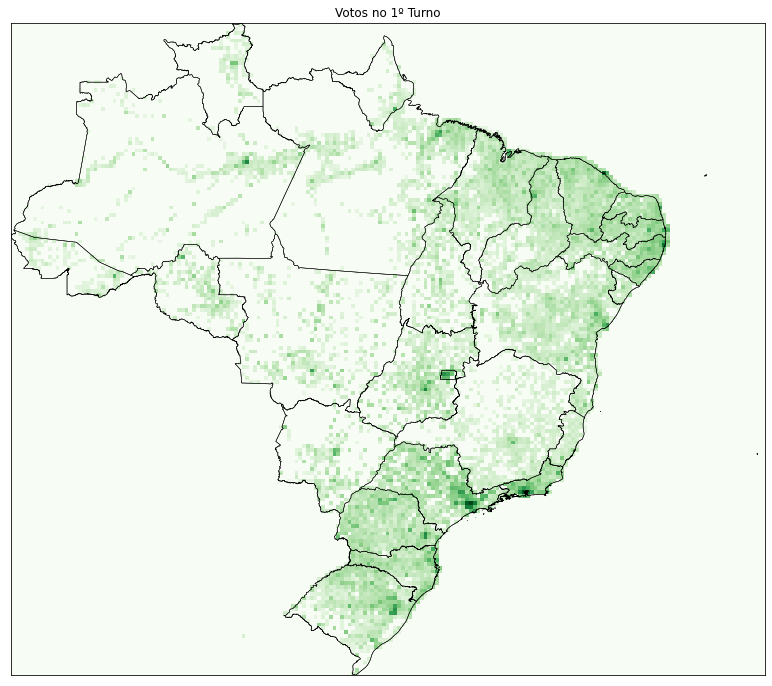

In [122]:
data = nth_root(turno22_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Greens")
plt.title("Votos no 1º Turno")
plt.show()

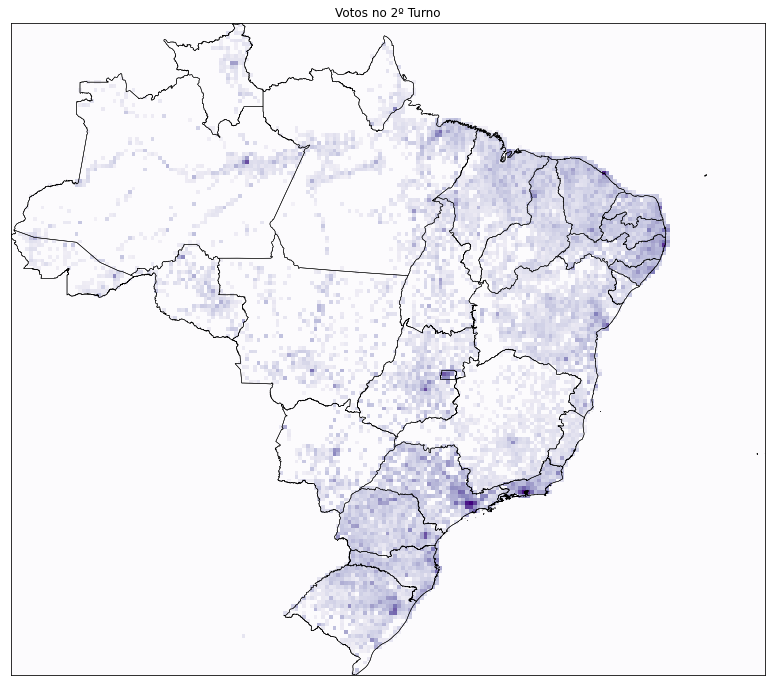

In [123]:
data = nth_root(turno22_2t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="Purples")
plt.title("Votos no 2º Turno")
plt.show()

**Análise:** Os votos seguem a densidade demográfica não sendo possível distinguir visualmente diferenças significativas entre votos do primeiro e do segundo turno.

Pode-se observar no mapa a existência de estados com baixa densidade demográfica mas elevada área territorial, sendo possível inferir a existência de algumas estruturas como o Rio Amazonas e a BR 163

## 2 - Existe diferença significativa regionalizada no quantitativo de votos no 1º e 2º turnos da eleição de 2022?

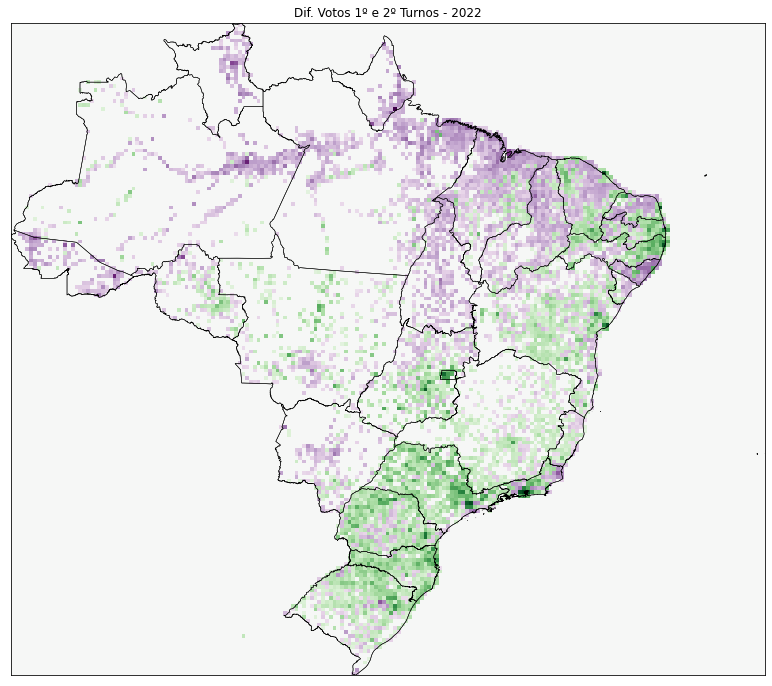

In [124]:
# Pergunta - Como foi o desempenho eleitoral dos principais candidatos no 1º turno da eleição de 2022
data = nth_root(turno22_2t - turno22_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="PRGn")
plt.title("Dif. Votos 1º e 2º Turnos - 2022")
plt.show()

**Análise:** Observa-se que a região Sul e Sudeste apresentaram um significativo aumento no número de votos no 2º turno.

A região nordeste, apesar de apresentar densidade populacional relevante, teve
uma significativa redução no quantitativo de votos registrados no segundo turno.

O estado do Mato Grosso apresenta uma anomalia. Observa-se aumento no quantitativo de votos em áreas de baixíssima densidade populacional. Em áreas
de densidade populacional equivalente, normalmente observa-se a redução do quantitativo de votos no 2º turno.

## 3 - Existe diferença significativa regionalizada no quantitativo de votos no 1º e 2º turnos da eleição de 2018?

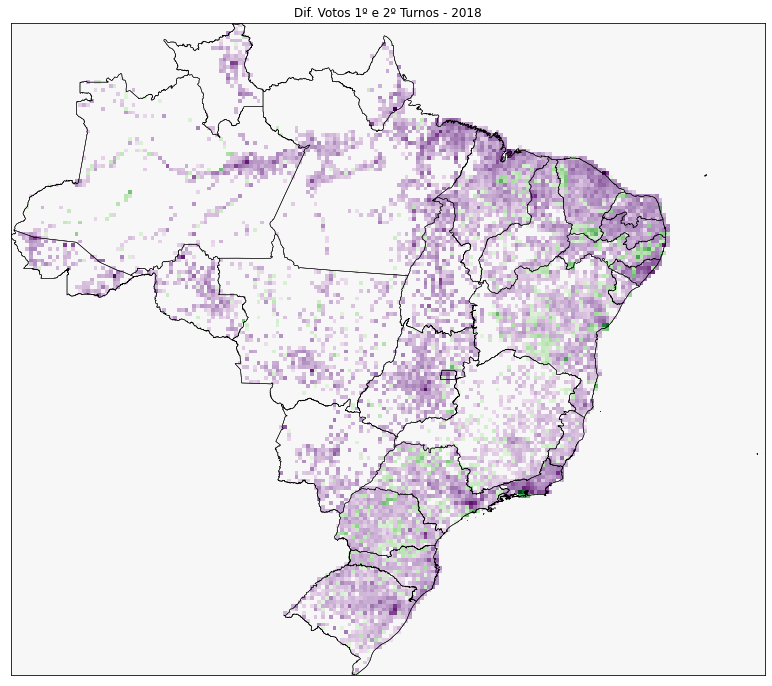

In [125]:
data = nth_root(turno18_2t - turno18_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="PRGn")
plt.title("Dif. Votos 1º e 2º Turnos - 2018")
plt.show()

**Análise:** No cenário eleitoral observado em 2018 observou-se que, de maneira geral, houve uma redução no número de votos no 2º turno em praticamente todas as regiões do país, delineando uma clara mudança no comportamento eleitoral quando comparado com os dados da eleição de 2022

## 4 - Onde situa-se o eleitorado dos 2 principais candidatos nas eleições de 2022?

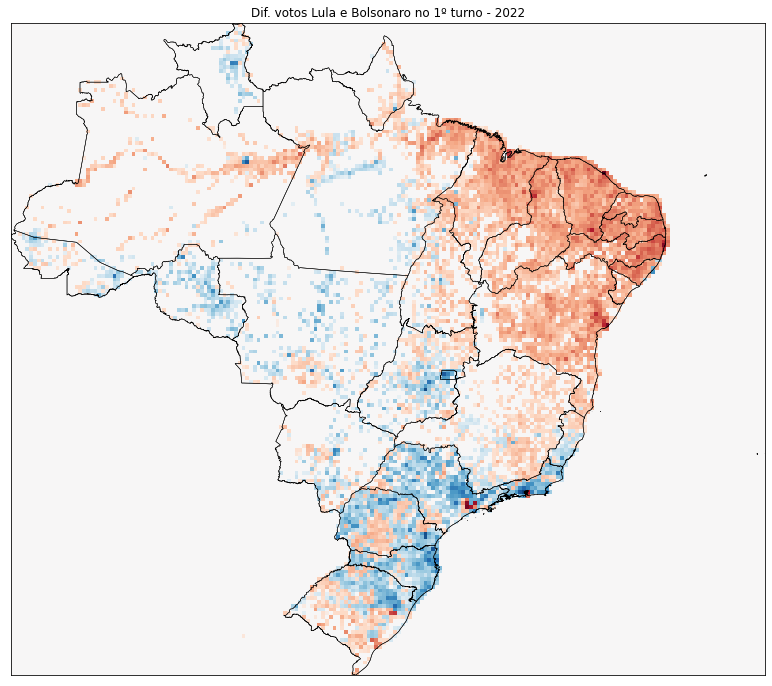

In [140]:
data = nth_root(lula22_1t - bolsonaro22_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r")
plt.title("Dif. votos Lula e Bolsonaro no 1º turno - 2022")
plt.show()

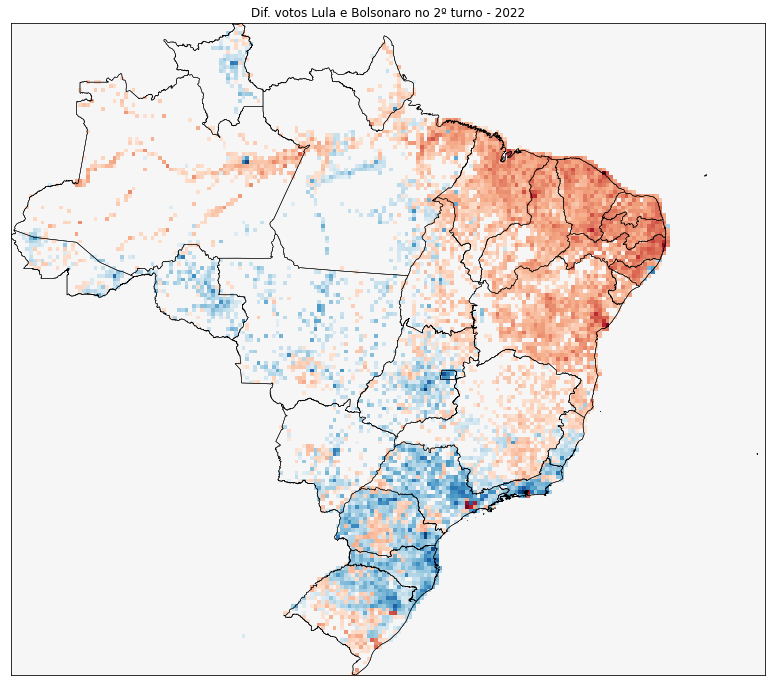

In [137]:
data = nth_root(lula22_2t - bolsonaro22_2t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r")
plt.title("Dif. votos Lula e Bolsonaro no 2º turno - 2022")
plt.show()

**Análise:** O eleitorado de Bolsonaro situa-se majoritariamente nas regiões Sul, Sudeste e Centro-Oeste. Já o eleitorado de Lula localiza-se da região centro norte de Minas e Norte do Espírito Santo e extende-se até o Nordeste do Pará.

O estado de Santa Catarina espacialmente é quase homogeneaemente todo bolsonarista, assim como Rio e São Paulo, mas diferentemente de Santa Catarina, as capitais destes dois últimos estados tiveram um número maior de votos para o candidato do PT.

Surpreendentemente, Paraná e Rio Grande do Sul apresentaram a existência de bolsões em que o apoio ao candidato do PT foi maior.

No nordestes, Bolsonaro conseguiu resultado expressivo em Maceió - AL.

Pará apresentou uma acentuada regionalização, com sua parte setentrional preferindo o candidato do PT

Visualmente não é possível identificar diferenças significativas na distribuição de votos entre o 1º e o 2º turno.

--- aprofundar ---

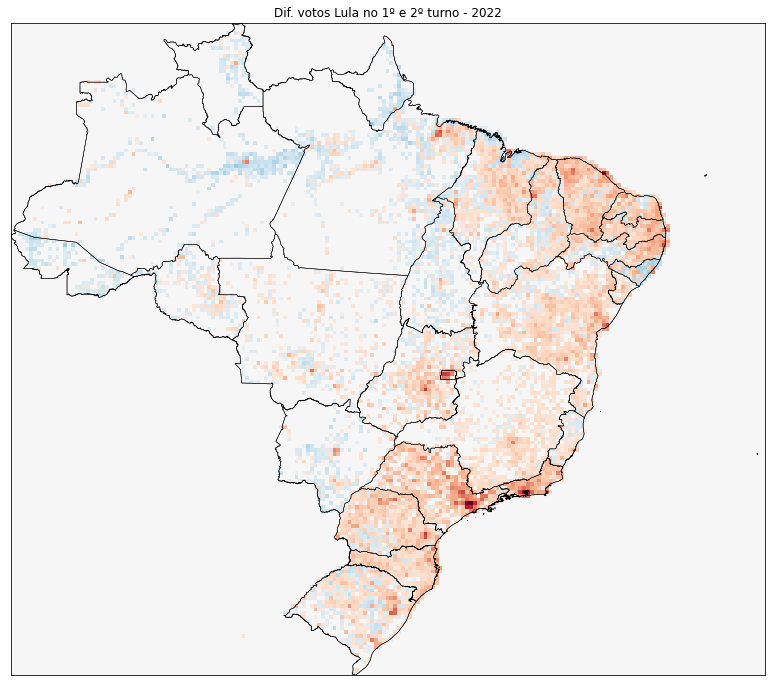

In [134]:
data = nth_root(lula22_2t - lula22_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r")
plt.title("Dif. votos Lula no 1º e 2º turno - 2022")
plt.show()

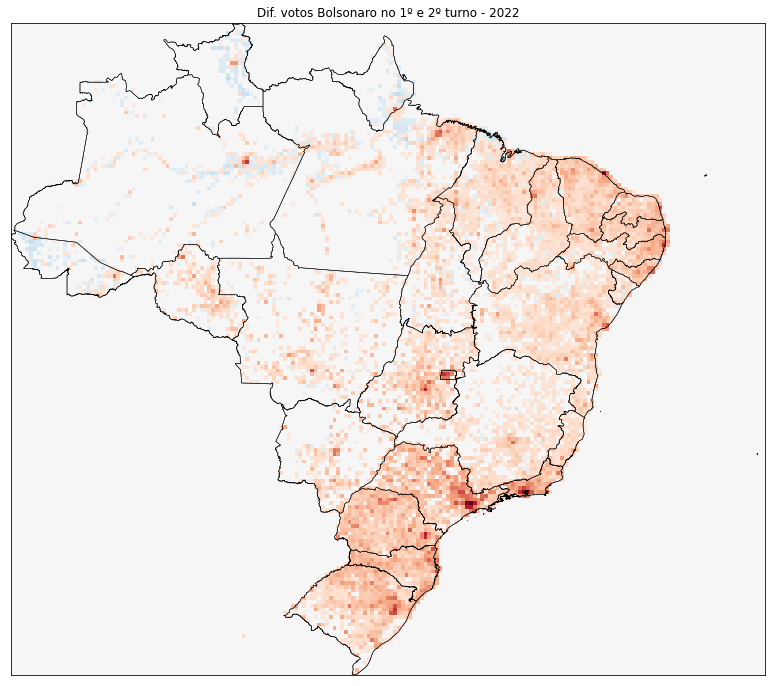

In [135]:
data = nth_root(bolsonaro22_2t - bolsonaro22_1t)
plt.figure(figsize=(FIG_X, FIG_Y))
m = draw_mesh_on_map(data, cmap="RdBu_r")
plt.title("Dif. votos Bolsonaro no 1º e 2º turno - 2022")
plt.show()